# Отток клиентов из «Бета-Банка»

<b>Задача:</b> Из «Бета-Банка» каждый месяц стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. Критерием оценки заказчик выбрал F1-measure.

<b>Признаки:</b>
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

<b>Целевой признак:</b>
- Exited — факт ухода клиента

---

In [1]:
# обработка данных
import pandas as pd
import numpy as np
import math

# визуализация
%matplotlib inline
%config InlineBckend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-notebook')
mpl.rcParams['figure.figsize'] = (11,7)

# работа с числовыми данным
from sklearn.preprocessing import MinMaxScaler

# работа с категориальными данными
from sklearn.preprocessing import OrdinalEncoder

# работа с обработанными данными
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# метрики
from sklearn.metrics import f1_score

import winsound
import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 100)

In [2]:
# прочитаем датасет библиотекой pandas
data = pd.read_csv('Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


---

## Первичный анализ

In [3]:
print(); print('Размер датасета:', data.shape[0], 'записей на', data.shape[1], 'признаков')
print('Обнаружено пропусков:', data.isna().sum().sum())
print('Обнаружено дубликатов:', data.duplicated().sum()); data = data.drop_duplicates()
print(); data.info()
print(); print(data.describe().loc[ : , 'CreditScore' : 'Balance'])


Размер датасета: 10000 записей на 14 признаков
Обнаружено пропусков: 909
Обнаружено дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.

<b>Итог:</b> 

- Признаки RowNumber, CustomerId и Surname будут удалены из-за неважности информации для модели обучения.

- Признак Tenure имеет логическое отклонение, так как счет в данном банке может быть открыт после 18 лет (об этом свидетельствует минимальный возраст), но даже 18 летний клиент, по данным банка, может иметь 10 летнюю лояльность (лояльность 19 летнего клиента может составлять максимум 1 год, 20 летнего максимум 2 и т.д.). Будет написан алгоритм для избавления от логических ошибок и написано обращение в поддержку банка, чтобы они выявили проблему в заполнении признака лояльности.

- Признак NumOfProducts является категориальным и имеет больше 2 категорий. Чтобы грамотно обучить модель, данный признак пройдет обработку через разбиение признаков One-Hot-Encoder.

- Признак Tenure имеет пропуски, которые будут заполнены методом ближайших соседей.

---

## Предобработка данных

In [4]:
# удаляем неважные признаки
features = data.drop(['CustomerId','RowNumber','Surname'], axis=1)

In [5]:
# используем One-Hot-Encoder и удаляем первый признак для избежания дамми-ловушки
features = pd.get_dummies(features, columns=['Geography', 'Gender'], drop_first=True)

In [6]:
# избавимся от логической ошибки признака Tenure 
features = features[(data['Age'] == 18) & (data['Tenure'] == 0) | (data['Age'] == 19) & (data['Tenure'] <= 1) |
                    (data['Age'] == 20) & (data['Tenure'] <= 2) | (data['Age'] == 21) & (data['Tenure'] <= 3) |
                    (data['Age'] == 22) & (data['Tenure'] <= 4) | (data['Age'] == 23) & (data['Tenure'] <= 5) |
                    (data['Age'] == 24) & (data['Tenure'] <= 6) | (data['Age'] == 25) & (data['Tenure'] <= 7) |
                    (data['Age'] == 26) & (data['Tenure'] <= 8) | (data['Age'] == 27) & (data['Tenure'] <= 9) |
                    (data['Age'] >= 28)]

In [7]:
# используем минимаксное шкалирование для равномерного распределения данных от 0 до 1
i = features.columns.drop('Tenure')
features = (pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(features[i]), columns=i)).join(data['Tenure'])

In [8]:
# заполняем пропуски алгоритмом ближайших соседей
def k_neighbors (data, column):
    
    k_features = data[data[column].isna() == False].drop(column, axis=1)
    k_target = data[data[column].isna() == False][column]
    k_features_nan = data[data[column].isna() == True].drop(column, axis=1)
    
    knn = KNeighborsClassifier(3, weights='distance')
    model = knn.fit(k_features, k_target)
    predictions = model.predict(k_features_nan)
    
    data.loc[data[column].isna() == True, column] = predictions
    
k_neighbors (features, 'Tenure')

In [9]:
# прошкалируем единственный оставшийся признак
features['Tenure'] = MinMaxScaler(feature_range=(0, 1)).fit_transform(features[['Tenure']])

In [10]:
# изучим, что получилось
display(features.head())
print(); print('Размер датасета:', features.shape[0], 'записей на', features.shape[1], 'признаков')
print('Обнаружено пропусков:', features.isna().sum().sum())
print('Обнаружено дубликатов:', features.duplicated().sum()); features = features.drop_duplicates()

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,Tenure
0,0.538,0.315068,0.000000,0.000000,1.0,1.0,0.506735,1.0,0.0,0.0,0.0,0.2
1,0.516,0.301370,0.334031,0.000000,0.0,1.0,0.562709,0.0,0.0,1.0,0.0,0.1
2,0.304,0.315068,0.636357,0.666667,1.0,0.0,0.569654,1.0,0.0,0.0,0.0,0.8
3,0.698,0.273973,0.000000,0.333333,0.0,0.0,0.469120,0.0,0.0,0.0,0.0,0.1
4,1.000,0.328767,0.500246,0.000000,1.0,1.0,0.395400,0.0,0.0,1.0,0.0,0.2



Размер датасета: 9629 записей на 12 признаков
Обнаружено пропусков: 0
Обнаружено дубликатов: 0


<b>Итог:</b> Пройдя путь предобработки, признаки обрели необходимый вид для их анализа моделью машинного обучения. Не осталось пропусков и дубликатов, а выбросы были ликвидированы минимаксным шкалированием.

---

## Визуализация

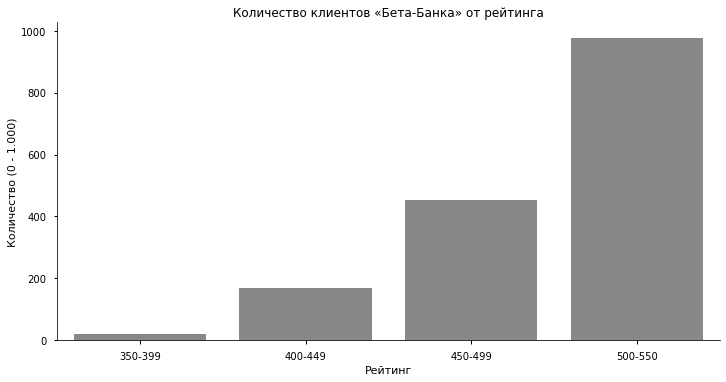

In [11]:
ax = pd.DataFrame(data.groupby('CreditScore')['Balance'].count()).reset_index()
ay = []
ay.append(ax[(ax['CreditScore'] >= 350) & (ax['CreditScore'] <= 400)]['Balance'].sum())
ay.append(ax[(ax['CreditScore'] > 400) & (ax['CreditScore'] <= 450)]['Balance'].sum())
ay.append(ax[(ax['CreditScore'] > 450) & (ax['CreditScore'] <= 500)]['Balance'].sum())
ay.append(ax[(ax['CreditScore'] > 500) & (ax['CreditScore'] <= 550)]['Balance'].sum())

ax = pd.DataFrame(ay, index=['350-399', '400-449', '450-499', '500-550']).reset_index()
sns.catplot(x='index', y=ax[0], data=ax, aspect=2, kind='bar', color='#888888')
plt.title('Количество клиентов «Бета-Банка» от рейтинга')
plt.ylabel('Количество (0 - 1.000)')
plt.xlabel('Рейтинг');

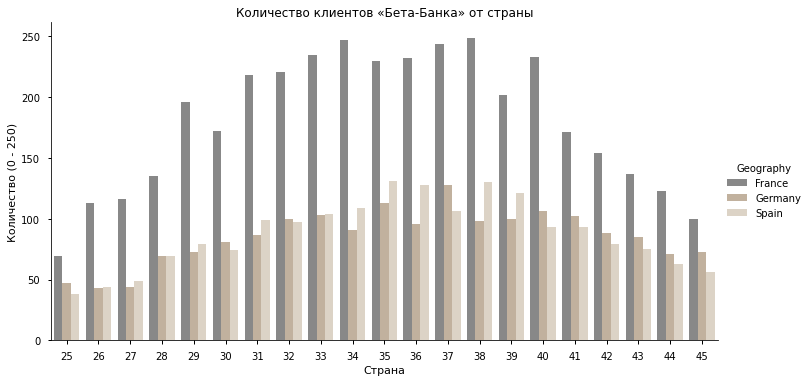

In [12]:
ax = pd.DataFrame(data.groupby(['Age', 'Geography'])['EstimatedSalary'].count()).loc[25:45].reset_index()
color = {'France' : '#888888', 'Germany' : '#C7B198', 'Spain' : '#DFD3C3'}
ax = sns.catplot(x='Age', y='EstimatedSalary', hue='Geography', data=ax, aspect=2, kind='bar', palette=color)
plt.title('Количество клиентов «Бета-Банка» от страны')
plt.ylabel('Количество (0 - 250)')
plt.xlabel('Страна');

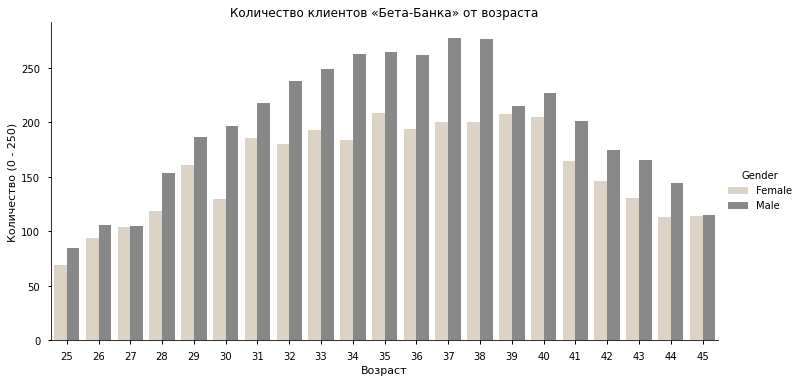

In [13]:
ax = pd.DataFrame(data.groupby(['Age', 'Gender'])['EstimatedSalary'].count()).loc[25:45].reset_index()
color = {'Male':'#888888', 'Female':'#DFD3C3'}
ax = sns.catplot(x='Age', y='EstimatedSalary', hue='Gender', data=ax, aspect=2, kind='bar', palette=color)
plt.title('Количество клиентов «Бета-Банка» от возраста')
plt.ylabel('Количество (0 - 250)')
plt.xlabel('Возраст');

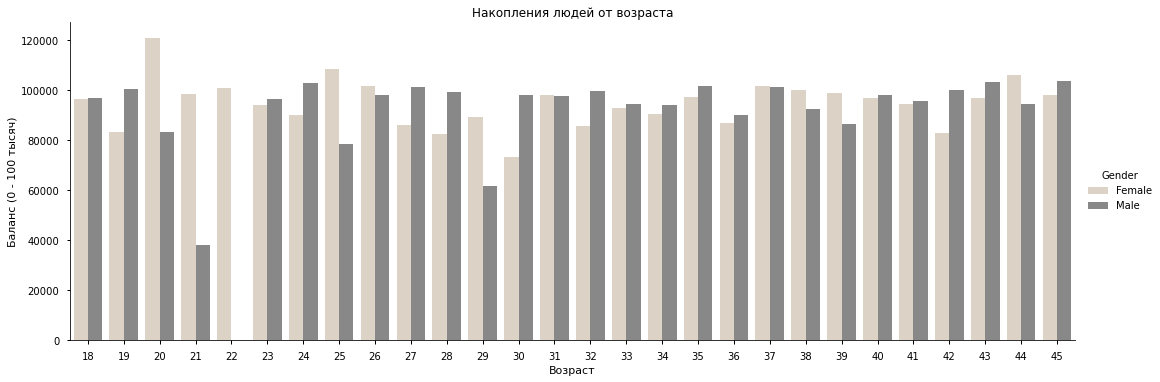

In [14]:
ax = pd.DataFrame(data.groupby(['Age', 'Gender'])['Balance'].median()).loc[18:45].reset_index()
color = {'Male':'#888888', 'Female':'#DFD3C3'}
ax = sns.catplot(x='Age', y='Balance', hue='Gender', data=ax, aspect=3, kind='bar', palette=color)
plt.title('Накопления людей от возраста')
plt.ylabel('Баланс (0 - 100 тысяч)')
plt.xlabel('Возраст');

<b>Итог:</b>  
- В банке больше всего людей с рейтингом 500-550 (высоким).
- Франция является самой перспективной страной для банка.
- Клиенты 34-38 летнего возраста являются самыми частыми клиентами.
- Накопления людей равномерно распределены, что вызывает подозрение. Даже 18 летние клиенты имеет на счету не меньше 100.000.

---

## Обучение моделей

In [15]:
# делим созданный датасет на признаки и целевой признак
target = features['Exited']
features = features.drop('Exited', axis=1)

In [16]:
# разделяем датасет на обучающую и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.9, random_state=20, stratify=target)

In [17]:
features_train.head()

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
6332,0.692,0.150685,0.000000,0.333333,1.0,1.0,0.044960,0.0,1.0,0.0,0.4
810,0.764,0.424658,0.579274,0.000000,0.0,0.0,0.459666,1.0,0.0,1.0,1.0
9419,0.582,0.397260,0.587256,0.000000,1.0,1.0,0.787310,0.0,0.0,0.0,0.1
8444,0.836,0.150685,0.000000,0.333333,1.0,1.0,0.997309,0.0,0.0,1.0,0.3
2448,0.400,0.356164,0.443437,0.000000,0.0,0.0,0.488106,1.0,0.0,0.0,1.0


---

#### LogisticRegression

In [18]:
model = LogisticRegression(random_state=20, class_weight='balanced')

model.fit(features_train, target_train)
predictions = model.predict(features_valid)

print('Результат метрики F1 для логистической регрессии:',f1_score(target_valid, predictions))

Результат метрики F1 для логистической регрессии: 0.5383177570093458


---

#### DecisionTreeClassifier

In [19]:
# ищем лучшие гиперпараметры для модели
#model = DecisionTreeClassifier(random_state=20, class_weight='balanced')
#
#parametrs = {'max_depth': np.arange(10, 30, 1),
#             'min_samples_split' : np.arange(2, 5, 1), 
#             'min_samples_leaf' : np.arange(2, 5, 1)}
#
#best_model = RandomizedSearchCV(model, parametrs, cv=3, n_jobs=-1, verbose=3, random_state=20)
#best_model.fit(features_train, target_train)

In [20]:
# ищем лучшие гиперпараметры для модели
#model = DecisionTreeClassifier(random_state=20, class_weight='balanced')
#
#parametrs = {'max_depth': np.arange(18, 22, 1),
#             'min_samples_split' : np.arange(2, 4, 1), 
#             'min_samples_leaf' : np.arange(2, 4, 1)}
#
#best_model = GridSearchCV(model, parametrs, cv=3, n_jobs=-1, verbose=3)
#best_model.fit(features_train, target_train)

In [21]:
model = DecisionTreeClassifier(random_state=20, class_weight='balanced',
                               max_depth=20, min_samples_leaf=2, min_samples_split=2)

model.fit(features_train, target_train)
predictions = model.predict(features_valid)

print('Результат метрики F1 для деревьев:',f1_score(target_valid, predictions))

Результат метрики F1 для деревьев: 0.5515695067264574


---

#### RandomForestClassifier

In [22]:
# ищем лучшие гиперпараметры для модели
#model = RandomForestClassifier(random_state=20, class_weight='balanced', bootstrap=True)
#
#parametrs = {'max_depth': np.arange(10, 30, 1),
#             'n_estimators': np.arange(10, 500, 10),
#             'min_samples_split' : np.arange(2, 5, 1), 
#             'min_samples_leaf' : np.arange(2, 5, 1)}
#
#best_model = RandomizedSearchCV(model, parametrs, cv=3, n_jobs=-1, verbose=3, random_state=20)
#best_model.fit(features_train, target_train)

In [23]:
# ищем лучшие гиперпараметры для модели
#model = RandomForestClassifier(random_state=20, class_weight='balanced', bootstrap=True)
#
#parametrs = {'max_depth': np.arange(24, 28, 1),
#             'n_estimators': np.arange(110, 150, 1),
#             'min_samples_split' : np.arange(2, 4, 1), 
#             'min_samples_leaf' : np.arange(2, 4, 1)}
#
#best_model = GridSearchCV(model, parametrs, cv=3, n_jobs=-1, verbose=3)
#best_model.fit(features_train, target_train)

In [24]:
model = RandomForestClassifier(random_state=20, class_weight='balanced', bootstrap=True,
                               max_depth=24, min_samples_leaf=2, min_samples_split=2, n_estimators=139)

model.fit(features_train, target_train)
predictions = model.predict(features_valid)

print('Результат метрики F1 для случайного леса:',f1_score(target_valid, predictions))

Результат метрики F1 для случайного леса: 0.6303724928366762


---

<b>Вывод:</b> Проведена обработка и анализ данных, после чего построены три модели: LogisticRegression, DecisionTree и RandomForest, лучшей из которых стала последняя. 

In [25]:
insound.MessageBeep()